# New Algorithms for Simulating Dynamical Friction

## Dan T. Abell, David L. Bruhwiler, Stephen D. Webb — *RadiaSoft, LLC*

This notebook describes—and documents in code—algorithms for simulating  
the dynamical friction experienced by ions in the presence of magnetized electrons.

The $\LaTeX$ preamble is *here*.
$$
%% math text
\newcommand{\hmhsp}{\mspace{1mu}}% math hair space
\newcommand{\mhsp}{\mspace{2mu}}% math hair space
\newcommand{\ud}{\mathop{}\!\mathrm{d}}% upright d for differential
\newcommand{\ui}{\mathrm{i}}% upright i for imaginary unit
\newcommand{\ue}{\mathrm{e}}% upright e for Euler number
%%
\newcommand{\Mion}{m_\text{ion}}
\newcommand{\Me}{m_\text{e}}
%%
\newcommand{\vQion}{\vec{q}_\text{ion}}
\newcommand{\vPion}{\vec{p}_\text{ion}}
\newcommand{\Qion}[1]{#1_\text{ion}}
\newcommand{\Pion}[1]{p_{\text{ion},\hmhsp#1}}
%%
\newcommand{\vQe}{\vec{q}_\text{e}}
\newcommand{\vPe}{\vec{p}_\text{e}}
\newcommand{\Qe}[1]{#1_\text{e}}
\newcommand{\Pe}[1]{p_{\text{e},\hmhsp#1}}
%%
\newcommand{\Map}[2][]{\mathcal{#2}^{#1}}
%%
\newcommand{\pgc}{p_\text{gc}}
\newcommand{\xgc}{x_\text{gc}}
\newcommand{\ygc}{y_\text{gc}}
$$

In [2]:
""" Python preamble """
%matplotlib inline

In [16]:
print mp

1.672621898e-27


In [3]:
""" Python preamble (cont.) """
from __future__ import division

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib as mpl

from scipy.constants import pi
from scipy.constants import speed_of_light as clight
from scipy.constants import epsilon_0 as eps0
from scipy.constants import mu_0 as mu0
from scipy.constants import elementary_charge as qe
from scipy.constants import electron_mass as me
from scipy.constants import proton_mass as mp
from scipy.constants import Boltzmann as kB
fourPiEps0 = 4 * pi * eps0
invFourPiEps0 = 1 / fourPiEps0

""" reset some default options """
np.set_printoptions(linewidth=96)

""" indexing """
(Ix, Ipx, Iy, Ipy, Iz, Ipz) = range(6)

""" prefixes """
(femto, pico, nano, micro, milli, one, kilo, mega, giga, tera, peta) = \
    10. ** np.asarray(range(-15, 15+1, 3))

We define the ion charge and mass here as global parameters.  
We do the same for the magnetic field strength $B$ and the  
thermal velocity $v_\text{th}$.  

Then we compute various related derived quantities.

In [4]:
"""
angular frequency of Larmor rotations
NB: This is a *signed* quantity, which means
that for electrons, say, you must set Z = -1.
"""
def omega_Larmor(mass, B, Z = 1):
    return Z * qe * B / mass

Z_ion = 1
M_ion = mp
B_mag = 1. # Tesla
e_temp = 300. # Kelvin

N_gyro = 100 # a somewhat arbitrary choice, range [100, 160] 

""" derived quantities """
V_th = math.sqrt(2 * kB * e_temp / me)
rho_gc = me * V_th / (qe * B_mag)
Omega_e = omega_Larmor(me, B_mag, Z = -1)
T_e = (2 * pi) / abs(Omega_e)
T_intxn = N_gyro * T_e

print "V_th = ", V_th
print "rho_gc / µm = ", rho_gc / micro
print "Omega_e / s^(-1) = ", Omega_e
print "frequency / GHz = ", Omega_e / (2 * pi) / giga
print "T_e / ns = ", T_e / nano
print "T_intxn / ns = ", T_intxn / nano

V_th =  95361.4171888
rho_gc / µm =  0.542189740332
Omega_e / s^(-1) =  -1.7588200236e+11
frequency / GHz =  -27.9924900765
T_e / ns =  0.0357238672682
T_intxn / ns =  3.57238672682


## Two-body Magnetized Collisions

The Hamiltonian for a two-body interaction between an ion and a magnetized electron is
$$
\vphantom{\Big]}
  H(\vQion, \vPion, \vQe, \vPe)
    = H_0(\vPion, \Qe{y}, \vPe)
    + H_\text{C}(\vQion, \vQe)
$$
where
$$
\begin{align}
  H_0(\vPion, \Qe{y}, \vPe)
    &= \frac{1}{2\Mion}\bigl(\Pion{x}^2 + \Pion{y}^2 + \Pion{z}^2\bigr)
     + \frac{1}{2\Me}\bigl((\Pe{x} + e B \Qe{y})^2 + \Pe{y}^2 + \Pe{z}^2\bigr),\\[1ex]
  H_\text{C}(\vQion, \vQe)
    &= -\frac{Ze^2}{4\pi\varepsilon_0} \big/
                {\sqrt{(\Qion{x}-\Qe{x})^2 + (\Qion{y}-\Qe{y})^2 + (\Qion{z}-\Qe{z})^2}},
\end{align}\\[1ex]
$$
and $e$ denotes the elementary quantum of charge.

The simplest second-order scheme for integrating this system uses  
a *split-operator* approach: We approximate the total map $\Map{M}$ for a  
time step of size $h$ by the symmetric form
$$
\vphantom{\Big]}
  \Map{M}(h) \approx \Map{M}_0(h/2) \Map{M}_C(h) \Map{M}_0(h/2)
$$
where $\Map{M}_0$ and $\Map{M}_C$ are the exact maps for the Hamiltonians $H_0$  
and $H_C$ respectively. The map $\Map{M}_0$ is a simple linear map. The map  
$\Map{M}_C$ generates a nonlinear kick of both ion and electron momenta.

### Hamiltonians for Two-body Magnetized Collisions

In [5]:
"""
Hamiltonian for free ion and electron in a magnetic field, under
the assuption that the ion is unaffected by that magnetic field.

Arguments:
  z_i (ndArray): 6 x N array of canonical coördinates
                 and conjugate momenta for the ions
  z_e (ndArray): 6 x N array of canonical coördinates
                 and conjugate momenta for the electrons
  In both of the above arrays, the six phase-space variables
  are given in the order(x, px, y, py, z, pz)

Return:
  the total 'free' energy of each ion-electron pair
  
"""
def H_twobody_0(z_i, z_e):
    ham_i = ((z_i[Ipx,:] ** 2 + z_i[Ipy,:] ** 2 + z_i[Ipz,:] ** 2)
             / (2 * M_ion))
    ham_e = ((z_e[Ipx,:] + (-qe) * B_mag * z_e[Iy,:]) ** 2
             + z_e[Ipy,:] ** 2 + z_e[Ipz,:] ** 2) / (2 * me)
    return ham_i + ham_e

"""
Hamiltonian for the interaction of each ion-electron pair.
"""
def H_twobody_C(z_i, z_e):
    g_ie = -(Z_ion * qe ** 2) / (4 * pi * eps0)
    intxn = g_ie / np.sqrt(
        + (z_i[Ix,:] - z_e[Ix,:]) ** 2
        + (z_i[Iy,:] - z_e[Iy,:]) ** 2
        + (z_i[Iz,:] - z_e[Iz,:]) ** 2)
    return intxn

"""
Total Hamiltonian for each ion-electron pair.
"""
def H_twobody(z_i, z_e):
    ham_0 = H_twobody_0(z_i, z_e)
    ham_C = H_twobody_C(z_i, z_e)
    return ham_0 + ham_C

### Maps for Two-body Magnetized Collisions

In [6]:
"""
define transfer maps for ions and electrons
There are three maps to define here: one each
for ions and electrons under H_0, and another
"""

""" matrix for a linear drift """
def MatD(mass, h):
    Mdrift = np.identity(6)
    for i in (Ix, Iy, Iz):
        Mdrift[i, i + 1] = h / mass
    return Mdrift

""" matrix for linear electron dynamics in a solenoidal field """
def MatK0_e(h):
    mw = me * Omega_e
    wh = Omega_e * h
    cwh = math.cos(wh)
    swh = math.sin(wh)
    cwh1m = 2 * math.sin(wh / 2) ** 2  # 1 - cos(a) = 2 sin^2(a / 2)
    MK0 = np.identity(6)
    MK0[Iy,  Iy ] = cwh
    MK0[Ipy, Ipy] = cwh
    MK0[Iy,  Ipy] = swh / mw
    MK0[Ipy, Iy ] = -mw * swh
    MK0[Iz,  Ipz] = h / me
    MK0[Ix,  Ipx] = swh / mw
    MK0[Ix,  Iy ] = swh
    MK0[Ix,  Ipy] = cwh1m / mw
    MK0[Iy,  Ipx] = -cwh1m / mw
    MK0[Ipy, Ipx] = -swh
    return MK0

"""
map phase-space coördinates forward in time by amount h
based on the Hamiltonian H_0, which describes the free
motion of ions and the motion of electrons in a solenoidal
magnetic field
"""
def MapZ_0(h, z_i, z_e):
    mat = MatD(M_ion, h)
    zf_i = mat.dot(z_i)
    mat = MatK0_e(h)
    zf_e = mat.dot(z_e)
    return zf_i, zf_e

"""
map phase-space coördinates forward in time by amount h
based on the Hamiltonian H_C, which describes the collision
between a single ion-electron pair
"""
def MapZ_C(h, z_i, z_e):
    g = h * Z_ion * qe ** 2 / (4 * pi * eps0)
    dz = z_i - z_e
    denom = (dz[Ix,:] ** 2 + dz[Iy,:] ** 2 + dz[Iz,:] ** 2) ** (3/2)
    zf_i = z_i.copy()
    zf_e = z_e.copy()
    for ip in (Ipx, Ipy, Ipz):
        zf_i[ip,:] = z_i[ip,:] - g * dz[ip - 1] / denom
        zf_e[ip,:] = z_e[ip,:] + g * dz[ip - 1] / denom
    return zf_i, zf_e

def apply_MapZ_0(h, n, z_i, z_e):
    mat_i = MatD(M_ion, h)
    mat_e = MatK0_e(h)
    zf_i = [z_i]
    zf_e = [z_e]
    for i in range(n):
        z_i = mat_i.dot(z_i)
        z_e = mat_e.dot(z_e)
        zf_i.append(z_i)
        zf_e.append(z_e)
    return np.asarray(zf_i), np.asarray(zf_e)

""" second-order split-operator integration for the total Hamiltonian """
def apply_MapZ(h, n, z_i, z_e):
    hh = 0.5 * h
    mat_i = MatD(M_ion, hh)
    mat_e = MatK0_e(hh)
    zf_i = [z_i]
    zf_e = [z_e]
    for i in range(n):
        z_i = mat_i.dot(z_i)
        z_e = mat_e.dot(z_e)
        z_i, z_e = MapZ_C(h, z_i, z_e)
        z_e = mat_e.dot(z_e)
        z_i = mat_i.dot(z_i)
        zf_i.append(z_i)
        zf_e.append(z_e)
    return np.asarray(zf_i), np.asarray(zf_e)

## Guiding-center Coördinates and $\Theta$-J Coördinates
### Transformations To and From Guiding-center Coördinates and $\Theta$-J Coördinates

We transform the electron's transverse phase-space coördinates  
using the type-1 generating function
$$
  F_1(x,y;\, \phi,\ygc)
    = m\Omega\Bigl[\frac{1}{2}(y - \ygc)^2\cot\phi - y \ygc\Bigr].
$$
This yields the following transformation rules:  
*to* guiding-center coördinates
$$
\begin{align}
  m\Omega &= qB_0,
               \quad\text{(this is a signed quantity)}\\[1ex]
  \phi    &= \arctan\Bigl(\frac{p_x + e B y}{p_y}\Bigr),\\[1ex]
  p_\phi  &= \frac{1}{2m\Omega}\bigl[(p_x + m\Omega y)^2 + p_y^2\bigr],\\[1ex]
  \ygc    &= -\frac{p_x}{m\Omega},\\[1ex]
  \pgc    &= p_y + m\Omega x.
\end{align}
$$
*from* guiding-center coördinates
$$
\begin{align}
  r_L &= \frac{1}{m\Omega}\sqrt{2m\Omega\,p_\phi},
           \quad\text{(this is a signed quantity)}\\[1ex]
  x   &= \frac{\pgc}{m\Omega} - r_L\cos\phi,\\[1ex]
  p_x &= -m\Omega\,\ygc,\\[1ex]
  y   &= \ygc + r_L\sin\phi,\\[1ex]
  p_y &= m\Omega\,r_L\cos\phi.
\end{align}
$$

We also require the transformation to and from the coördinates $\Theta$-J:
$$
\begin{align}
  \Theta &= \dotsb, \\
  J &= p_\phi + \frac{Ze^2}{4\pi\varepsilon_0} \frac{r_L}{\Omega}
      \frac{(\Qion{x}-\xgc)\cos\phi - (\Qion{y}-\ygc)\sin\phi}{%
        \bigl[(\Qion{x}-\Qe{x})^2 + (\Qion{y}-\Qe{y})^2 + (\Qion{z}-\Qe{z})^2
              + r_L^2\bigr]^{3/2}}.
\end{align}
$$

$$
\begin{align}
  \phi &= \dotsb, \\
  p_\phi &=  \dotsb.
\end{align}
$$

In [7]:
""" convert to guiding-center coordinates """
def toGuidingCenter(z_e):
    mOmega = me * Omega_e
    zgc = z_e.copy()
    zgc[Ix,:]  = np.arctan2(z_e[Ipx,:] + mOmega * z_e[Iy,:], z_e[Ipy,:])
    zgc[Ipx,:] = (((z_e[Ipx,:] + mOmega * z_e[Iy,:]) ** 2
                   + z_e[Ipy,:] ** 2) / (2 * mOmega))
    zgc[Iy,:]  = - z_e[Ipx,:] / mOmega
    zgc[Ipy,:] = z_e[Ipy,:] + mOmega * z_e[Ix,:]
    return zgc

""" convert from guiding-center coordinates """
def fromGuidingCenter(zgc):
    mOmega = me * Omega_e
    rhoL = np.sqrt(2 * mOmega * zgc[Ipx,:]) / mOmega
    z_e = zgc.copy()
    z_e[Ix,:]  = zgc[Ipy,:] / mOmega - rhoL * np.cos(zgc[Ix,:])
    z_e[Ipx,:] = - mOmega * zgc[Iy,:]
    z_e[Iy,:]  = zgc[Iy,:] + rhoL * np.sin(zgc[Ix,:])
    z_e[Ipy,:] = mOmega * rhoL * np.cos(zgc[Ix,:])
    return z_e

""" return J(z_gc) coordinates using the (probably correct) minus sign """
def actionJ(z_i, zgc):
    g = Z_ion * qe ** 2 / (4 * pi * eps0)
    mOmega = me * Omega_e
    rhoL = np.sqrt(2 * zgc[Ipx,:] / mOmega)
    num = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) * np.cos(zgc[Ix,:])
        -  (z_i[Iy,:] - zgc[Iy,:]) * np.sin(zgc[Ix,:]))
    den = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) ** 2
        +  (z_i[Iy,:] - zgc[Iy,:]) ** 2
        +  (z_i[Iz,:] - zgc[Iz,:]) ** 2 + rhoL ** 2) ** (3/2)
    return zgc[Ipx,:] + g * (rhoL / Omega_e) * num / den

In [8]:
""" return the Larmor radius """
def rLarmor(z_e):
    mOmega = me * Omega_e
    return np.sqrt((z_e[Ipx,:] + mOmega * z_e[Iy,:]) ** 2 + z_e[Ipy,:] ** 2) / mOmega

""" return the Larmor radius """
def rLarmor_gc(zgc):
    mOmega = me * Omega_e
    return np.sqrt(2 * mOmega * zgc[Ipx,:]) / mOmega

""" return the perturbation ratio (uses the minus sign) """
def pertubationRatio(z_i, zgc):
    mOmega = me * Omega_e
    rhoL = np.sqrt(2 * mOmega * zgc[Ipx,:]) / mOmega
    num = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) * np.cos(zgc[Ix,:])
           - (z_i[Iy,:] - zgc[Iy,:]) * np.sin(zgc[Ix,:]))
    den = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) ** 2
        +  (z_i[Iy,:] - zgc[Iy,:]) ** 2
        +  (z_i[Iz,:] - zgc[Iz,:]) ** 2 + rhoL ** 2)
    return 2 * rhoL * num / den

""" return the ratio (impact parameter) / (Larmor radius) """
def impactParamOverRL(z_i, zgc):
    mOmega = me * Omega_e
    rhoL = np.sqrt(2 * mOmega * zgc[Ipx,:]) / mOmega
    b = np.sqrt((z_i[Ix,:] - zgc[Ipy,:] / mOmega) ** 2
               + (z_i[Iy,:] - zgc[Iy,:]) ** 2)
    return b / rhoL

### Hamiltonians using Guiding-center Coördinates

In [9]:
"""
Hamiltonian for free ion and electron in a magnetic field, under
the assuption that the ion is unaffected by that magnetic field.
"""
def H_gc_0(z_i, zgc):
    ham_i = ((z_i[Ipx,:] ** 2 + z_i[Ipy,:] ** 2 + z_i[Ipz,:] ** 2)
             / (2 * M_ion))
    ham_e = Omega_e * actionJ(z_i, zgc) + zgc[Ipz,:] ** 2 / (2 * me)
    return ham_i + ham_e

"""
Hamiltonian for the ion-electron interaction
in guiding-center (Θ,J) coördinates.
"""
def H_gc_C(z_i, zgc):
    g_ie = (Z_ion * qe ** 2) / (4 * pi * eps0)
    mOmega = me * Omega_e
    intxn = -g_ie / np.sqrt(
        + (z_i[Ix,:] - zgc[Ipy,:] / mOmega) ** 2
        + (z_i[Iy,:] - zgc[Iy,:]) ** 2
        + (z_i[Iz,:] - zgc[Iz,:]) ** 2
        + 2 * actionJ(z_i, zgc) / mOmega)
    return intxn

"""
total Hamiltonian for the ion-electron system in GC coördinates
"""
def H_gc(z_i, zgc):
    ham_0 = H_gc_0(z_i, zgc)
    ham_C = H_gc_C(z_i, zgc)
    return ham_0 + ham_C

"""
Hamiltonian for the ion-electron interaction
in guiding-center (Θ,J) coördinates.
"""
def H_gc_Cp(z_i, zgc):
    g_ie = (Z_ion * qe ** 2) / (4 * pi * eps0)
    mOmega = me * Omega_e
    intxn = -g_ie / np.sqrt(
        + (z_i[Ix,:] - zgc[Ipy,:] / mOmega) ** 2
        + (z_i[Iy,:] - zgc[Iy,:]) ** 2
        + (z_i[Iz,:] - zgc[Iz,:]) ** 2
        + 2 * actionJp(z_i, zgc) / mOmega)
    return intxn

"""
total Hamiltonian for the ion-electron system in GC coördinates
"""
def H_gc_m(z_i, zgc):
    ham_0 = H_gc_0(z_i, zgc)
    ham_C = H_gc_Cm(z_i, zgc)
    return ham_0 + ham_C

### Maps using Guiding-center Coördinates

In [10]:
"""
define transfer maps for ions and electrons
There are three maps to define here: one each
for ions and electrons under H_0, and another
for the interaction under H_c
"""

"""
Map phase-space coördinates forward in time by amount h.
This map is based on the Hamiltonian H_gc_0, which describes
the free motion of ions and the averaged motion of electrons
in a solenoidal magnetic field.
NB: We do not update the \Theta coördinate, as it does not
contribute to the dynamics of any other variables.
"""
def MapZgc_0(h, z_i, zgc):
    matD = MatD(M_ion, h)
    zf_i = matD.dot(z_i)
    zf_e = zgc.copy()
    zf_e[Iz,:] += (h / me) * zgc[Ipz,:]
    return zf_i, zf_e

"""
Map phase-space coördinates forward in time by amount h.
This map is based on the Hamiltonian H_gc_C, which describes
the collision between a single ion-electron pair in guiding-center
coördinates.
NB: We do not update the \Theta coördinate, as it does not
contribute to the dynamics of any other variables.
"""
def MapZgc_C(h, z_i, zgc):
    g_ie = Z_ion * qe ** 2 / (4 * pi * eps0)
    mOmega = me * Omega_e
    dr3 = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) ** 2
           + (z_i[Iy,:] - zgc[Iy,:]) ** 2
           + (z_i[Iz,:] - zgc[Iz,:]) ** 2
           + (2 / mOmega) * actionJ(z_i, zgc)) ** (3/2)
    Omega_gc = (g_ie / mOmega) / dr3
    S = np.sin(Omega_gc * h)
    C1 = 2 * np.sin(Omega_gc * (h / 2)) ** 2
    zf_i = z_i.copy()
    zf_e = zgc.copy()
    Dxgc = ((z_i[Ix,:] - zgc[Ipy,:] / mOmega) * C1
            + (z_i[Iy,:] - zgc[Iy,:]) * S)
    Dygc = ((z_i[Iy,:] - zgc[Iy,:]) * C1
            - (z_i[Ix,:]- zgc[Ipy,:] / mOmega) * S)
    Dpz = (Omega_gc * h) * mOmega * (z_i[Iz,:] - zgc[Iz,:])
    zf_i[Ipx,:] += mOmega * Dygc
    zf_i[Ipy,:] -= mOmega * Dxgc
    zf_i[Ipz,:] -= Dpz
    zf_e[Iy,:]  += Dygc
    zf_e[Ipy,:] += mOmega * Dxgc
    zf_e[Ipz,:] += Dpz
    return zf_i, zf_e

def apply_MapZgc_0(h, n, z_i, zgc):
    mat_i = MatD(M_ion, h)
    mat_e = np.identity(6)
    mat_e[Iz, Ipz] = h / me
    zf_i = [z_i]
    zf_e = [zgc]
    for i in range(n):
        z_i = mat_i.dot(z_i)
        zgc = mat_e.dot(zgc)
        zf_i.append(z_i)
        zf_e.append(zgc)
    return np.asarray(zf_i), np.asarray(zf_e)

def apply_MapZgc(h, n, z_i, zgc):
    hh = 0.5 * h
    mat_i = MatD(M_ion, hh)
    mat_e = np.identity(6)
    mat_e[Iz, Ipz] = hh / me
    zf_i = [z_i]
    zf_e = [zgc]
    for i in range(n):
        z_i = mat_i.dot(z_i)
        zgc = mat_e.dot(zgc)
        z_i, zgc = MapZgc_C(h, z_i, zgc)
        zgc = mat_e.dot(zgc)
        z_i = mat_i.dot(z_i)
        zf_i.append(z_i)
        zf_e.append(zgc) 
    return np.asarray(zf_i), np.asarray(zf_e)

### Maps using the Magnus Expansion

In [11]:
"""
compute $\Delta P_\text{ion}$ using the Magnus expansion
"""
def magnus_deltaPIon(h, z_i, zgc):
    g_ie = (Z_ion * qe ** 2) / (4 * pi * eps0)
    mOmega = me * Omega_e
    xgc = zgc[Ipy,:] / mOmega
    C1 = ((z_i[Ix,:] - xgc) ** 2
        + (z_i[Iy,:] - zgc[Iy,:]) ** 2
        + (z_i[Iz,:] - zgc[Iz,:]) ** 2
        + (2 / mOmega) * actionJ(z_i, zgc))
    C2 = (2 * ((z_i[Ix,:] - xgc) * z_i[Ipx,:] / M_ion
             + (z_i[Iy,:] - zgc[Iy,:]) * z_i[Ipy,:] / M_ion
             + (z_i[Iz,:] - zgc[Iz,:]) * (z_i[Ipz,:] / M_ion - zgc[Ipz,:] / me)))
    C3 = ((z_i[Ipx,:] / M_ion) ** 2
        + (z_i[Ipy,:] / M_ion) ** 2
        + (z_i[Ipz,:] / M_ion - zgc[Ipz,:] / me) ** 2)
    B = np.sqrt(C1 + (C2 + C3 * h) * h)
    Delta = 4 * C1 * C3 - C2 ** 2
    D1 = (2 * C3 * h + C2) / B - C2 / np.sqrt(C1)
    D2 = (C2 * h + 2 * C1) / B - 2 * np.sqrt(C1)
    dPx = - ((2 * g_ie / Delta) *
             ((z_i[Ix,:] - xgc) * D1 - (z_i[Ipx,:] / M_ion) * D2))
    dPy = - ((2 * g_ie / Delta) *
             ((z_i[Iy,:] - zgc[Iy,:]) * D1 - (z_i[Ipy,:] / M_ion) * D2))
    dPz = - ((2 * g_ie / Delta) *
             ((z_i[Iz,:] - zgc[Iz,:]) * D1 - (z_i[Ipz,:] / M_ion - zgc[Ipz,:] / me) * D2))
    return np.asarray(( dPx, dPy, dPz)).T

In [12]:
"""
For the Magnus computation to work well, the interaction must be perturbative.
This function return a value for the minimum impact parameter, above which the
interaction becomes perturbative.
"""
def minImpactParam(magB, EkOverEV, bOverRL):
    numer = 2 * EkOverEV * (invFourPiEps0 * Z_ion * me)
    denom = ((1 / bOverRL) ** 2 + (tan_alpha / (N_gyro * pi)) ** 2) * magB ** 2
    return (numer / denom) ** (1/3)

### Conversion from (*Q*,*V*) to (*Q*,*P*)

In [13]:
"""
define matrix that transforms ion coördinate-velocity data
to canonically conjugate phase-space variables
"""
QVtoZion = np.identity(6)
for i in (Ipx, Ipy, Ipz):
    QVtoZion[i, i] = M_ion

"""
define matrix that transforms electron coördinate-velocity data
to canonically conjugate phase-space variables
NB: This depends on the local magnetic vector potential,
hence on the local magnetic field.
"""
QVtoZe = np.identity(6)
for i in (Ipx, Ipy, Ipz):
    QVtoZe[i, i] = me
QVtoZe[Ipx, Iy] = (-qe) * (-B_mag)

# Explore a range of values for the perturbation parameters

In [14]:
Z_ion = 1
M_ion = mp
e_temp = 300. # Kelvin
B_mag = 1. # Tesla

N_gyro = 100    # enforce adequate averaging
tan_alpha = 5.0 # and an adequate opening angle

""" derived quantities """
Omega_e = omega_Larmor(me, B_mag, Z = -1)
T_e = (2 * pi) / abs(Omega_e)

In [17]:
bOverLarmorR = 20.0 # 20 ==> max perturbation ratio of about 0.1
EkinOverVmax = 10.0 # 10 ==> eV_closest_approach / E_kinetic = 0.1
print minImpactParam(B_mag, EkinOverVmax, bOverLarmorR) / micro

3.90333173895


In [26]:
decades = 2
pts_per_decade = 3
logBs = np.linspace(0., 1. * float(decades), num = 1 + pts_per_decade * decades, endpoint = True)
bvals = np.power(10, logBs)
impactParameterB = micro * bvals

print "b / μm =    ", impactParameterB / micro
print "b_min / μm =", minImpactParam(B_mag, EkinOverVmax, bOverLarmorR) / micro

b / μm =     [   1.            2.15443469    4.64158883   10.           21.5443469    46.41588834  100.        ]
b_min / μm = 3.90333173895


In [27]:
""" (the following depend on the impact parameter) """
LarmorR = impactParameterB / bOverLarmorR  # (this version is defined positive)
V_perp = - LarmorR * Omega_e
L_intxn = tan_alpha * impactParameterB #[-1] * np.ones_like(impactParameterB)
V_z = 2 * L_intxn / (N_gyro * T_e)
T_intxn = 2 * L_intxn / V_z

In [28]:
num_steps_per_gyro = 40
delta_Te = T_e / num_steps_per_gyro
print T_intxn / delta_Te
num_steps = int(np.floor(T_intxn[0] / delta_Te))
print "num_steps =", num_steps

[ 4000.  4000.  4000.  4000.  4000.  4000.  4000.]
num_steps = 4000


In [29]:
""" initial condition for the ion --- just one, for now """
QVion = np.array([
          ( 0.0 * rho_gc,  0.000 * V_th, 0.0 * rho_gc,  0.000 * V_th, 0.0,  0.000 * V_th)
        ]).transpose()
Zion = QVtoZion.dot(QVion)

""" initial conditions for the electrons """
QVelec = np.asarray([
           np.zeros(impactParameterB.shape),
           V_perp,
           impactParameterB - LarmorR,
           np.zeros(impactParameterB.shape),
           - L_intxn,
           L_intxn * abs(Omega_e) / (pi * N_gyro)
        ])
Zelec = QVtoZe.dot(QVelec)

num_elec0 = Zelec.shape[1]
num_ion0 = Zion.shape[1]

"""
=== create arrays of electrons and ions ===
Here we arrange them so that we can pair each ion with each
electron, and compute the \Delta{p} for each interaction.
"""
ZI_elec = np.hstack([Zelec for e in range(num_ion0)])
ZI_ion = Zion[:, np.arange(num_ion0 * num_elec0) // num_elec0]

num_elec = ZI_elec.shape[1]
num_ion = ZI_ion.shape[1]

In [30]:
ZF_i, ZF_e = apply_MapZ(delta_Te, num_steps, ZI_ion, ZI_elec)

In [31]:
navg = 1 # number of gyrotron oscillations over which to average; set to 1, 2, 4, 5, or 10
ZI_elec_gc = toGuidingCenter(ZI_elec)
ZFgc_i, ZFgc_e = apply_MapZgc(navg * 40*delta_Te, num_steps//40 // navg, ZI_ion, ZI_elec_gc)

In [32]:
deltaP_exp = np.array(ZF_i[-1, [Ipx, Ipy, Ipz], :] - ZF_i[0, [Ipx, Ipy, Ipz], :]).T
deltaP_avg = np.array(ZFgc_i[-1, [Ipx, Ipy, Ipz], :] - ZFgc_i[0, [Ipx, Ipy, Ipz], :]).T
deltaP_mgn = magnus_deltaPIon(T_intxn, ZI_ion, ZI_elec_gc)

print deltaP_exp
print
print deltaP_avg
print
print deltaP_mgn

[[  1.08030578e-26   5.72808106e-26   1.45007842e-27]
 [  4.03458322e-28   1.66767979e-26   1.38486416e-27]
 [  2.76032939e-29   6.40599505e-27   9.05956974e-29]
 [  7.85620796e-31   1.58638251e-27   2.60010730e-30]
 [  1.75039675e-32   3.47567664e-28   5.80271684e-32]
 [  3.78408946e-34   7.50099341e-29   1.25468090e-33]
 [  8.15538018e-36   1.61631831e-29   2.70410697e-35]]

[[  1.05836708e-26   5.67504416e-26   8.51768805e-28]
 [  4.00940540e-28   1.66262914e-26   1.38431451e-27]
 [  2.74641067e-29   6.39066436e-27   9.05285901e-29]
 [  7.81439841e-31   1.58238970e-27   2.59745819e-30]
 [  1.74099270e-32   3.46684860e-28   5.79654896e-32]
 [  3.76373889e-34   7.48192282e-29   1.25334141e-33]
 [  8.11151685e-36   1.61220857e-29   2.70121883e-35]]

[[ -0.00000000e+00   1.61222627e-25  -1.01894869e-40]
 [ -0.00000000e+00   3.47345583e-26  -3.78365367e-41]
 [ -0.00000000e+00   7.48333795e-27  -0.00000000e+00]
 [ -0.00000000e+00   1.61223638e-27  -0.00000000e+00]
 [ -0.00000000e+00   3.4

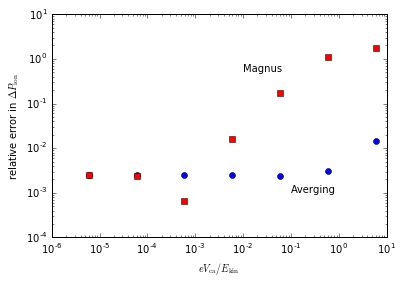

In [33]:
dDeltaP_ax = deltaP_avg - deltaP_exp
dDeltaP_mx = deltaP_mgn - deltaP_exp

relErr_avg = (np.linalg.norm(dDeltaP_ax, axis = 1)
             / np.linalg.norm(deltaP_exp, axis = 1))
relErr_mgn = (np.linalg.norm(dDeltaP_mx, axis = 1)
             / np.linalg.norm(deltaP_exp, axis = 1))

eV_closest_approach = (invFourPiEps0 * Z_ion * qe ** 2 / impactParameterB)
E_kinetic_e = (me / 2) * (V_perp ** 2 + V_z ** 2)
eVcaOverEkin = eV_closest_approach / E_kinetic_e

llres = plt.figure()
plt.loglog(eVcaOverEkin, relErr_avg, 'bo')
plt.loglog(eVcaOverEkin, relErr_mgn, 'rs')
plt.annotate(s="Averging",xy=(1.e-1,1.e-3))
plt.annotate(s="Magnus",xy=(1.e-2,5.e-1))

plt.xlabel("$eV_{\mathrm{ca}} / E_{\mathrm{kin}}$")
plt.ylabel("relative error in $\Delta{P}_{\mathrm{ion}}$")

plt.show()

llres.savefig("/Users/dabell/Desktop/foo.pdf")

In [ ]:
mae_compare.savefig("/Users/dabell/RadiaSoft/MCool/MgnAvgExpCompare.pdf")